In [5]:
import qutip as qt
import qutip.piqs as pq
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from qutip.measurement import measure

np.set_printoptions(threshold=np.inf)
qt.qutip.about()

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16}) # The default font in LaTex
# font.family        : serif
# font.serif         : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
# font.sans-serif    : Helvetica, Avant Garde, Computer Modern Sans serif
# font.cursive       : Zapf Chancery
# font.monospace     : Courier, Computer Modern Typewriter
# text.usetex        : true
plt.rc('text', usetex=True)


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.3.post1
Numpy Version:      2.0.1
Scipy Version:      1.14.0
Cython Version:     3.0.11
Matplotlib Version: 3.9.1.post1
Python Version:     3.12.4
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /opt/anaconda3/envs/qutip/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can 

In [6]:
# Coefficients of collapse operators in PI Basis
def bm(j,m):
    return (-np.sqrt((j+m)*(j+m-1)))

def dm(j,m):
    return (np.sqrt((j-m+1)*(j-m+2)))

def bp(j,m):
    return (np.sqrt((j-m)*(j-m-1)))

def dp(j,m):
    return (-np.sqrt((j+m+1)*(j+m+2)))

def bz(j,m):
    return (np.sqrt((j-m)*(j+m)))

def dz(j,m):
    return (np.sqrt((j+m+1)*(j-m+1)))

def cj(N,J):
    if J== N/2:
        return (1/(2*J))

    else:
        return ((1/(2*(J)))*((N/2+1)/(J+1)))

def cjp1(N,J):
    return ((1/(2*(J+1)))*((N/2-J)/(2*J+1)))

def cjm1(N,J):
    return ((1/(2*(J)))*((N/2+J+1)/(2*J+1)))

def rate(ch,p,q,N,J,M,dr=1,dt=1):
    r = 0;
    if p==-1:
        if q==-1:
            r = bm(J,M)
        elif q==0:
            r = bz(J,M)
        else:
            r = bp(J,M)
    elif p==0:
        if q==-1:
            r = pq.am(J,M)
            #if ch=='l':
                #r *= cjm1(N,J)
        elif q==0:
            r = M
            #if ch=='l':
                #r *= cjm1(N,J)
        else:
            r = pq.ap(J,M)
            #if ch=='l':
                #r *= cjm1(N,J)
    elif p==1:
        if q==-1:
            r = dm(J,M)
        elif q==0:
            r = dz(J,M)
        else:
            r = dp(J,M)

    else:
        # Continuous dephasing
        r = 1-1j*dt*(-1j*dr[0]*(N/2+M)/2 - 1j*dr[2]*(N/2-M)/2 - 1j*dr[1]*(N/4)/2)
        
    return r

def EncodedSt(M1, M2, α, β, ch, N, J):
    if J<=abs(M1):
        J = abs(M1)
        
    j  = np.array([jj for jj in np.linspace(N/2,N%2/2,int(N//2+1))])
    mj = np.array([int(2*jj+1) for jj in j])
    dim = np.sum(mj)
    st_ind = np.sum(mj[:np.where(j==J)[0][0]])

    Log0 = np.zeros((dim,1),dtype=np.complex128)
    Log1 = np.zeros((dim,1),dtype=np.complex128)

    if ch:
        cm1 = np.sqrt(M2/(M1+M2))
        cm2 = np.sqrt(M1/(M1+M2))
    
        #Logical 0 state
        Log0[st_ind+J-M1] = α*cm1
        Log0[st_ind+J+M2] = α*cm2
    
        #Logical 1 state
        Log1[st_ind+J+M1] = β*cm1
        Log1[st_ind+J-M2] = β*cm2

    else:
        #Logical 0 state
        Log0[st_ind+J-J] = 1
    
        #Logical 1 state
        Log0[st_ind+J-(-J+1)] = 1
        
    Log0 = qt.Qobj(Log0)
    Log1 = qt.Qobj(Log1)
    
    #Encoded state
    EncSt = Log0 + Log1

    return EncSt

def dec_St(St,merr,N,J):
    j  = np.array([jj for jj in np.linspace(N/2,N%2/2,int(N//2+1))])
    mj = np.array([int(2*jj+1) for jj in j])
    dim = np.sum(mj)
    st_ind = np.sum(mj[:np.where(j==J)[0][0]])

    # Finding M levels occupied in the input state in J subspace
    i, _ = np.nonzero(St.data_as("ndarray"))
    mi = [st_ind+J-i[ind] for ind in range(len(i))]

    # Coefficients in individual decay
    
    Md1 = [rate('l',-1,merr,N,J,mi[ind]) for ind in range(len(mi))]
    Md2 = [rate('l',0,merr,N,J,mi[ind]) for ind in range(len(mi))]
    Md3 = [rate('l',1,merr,N,J,mi[ind]) for ind in range(len(mi))]
    
    # Finding possible J subspaces after decay and their coefficients
    if J==N/2:
        Jdec = [J-1,J]
        Cdec = [cjm1(N,J),cj(N,J)]
        Mdec = [Md1,Md2]

    elif J>0 and J<N/2:
        Jdec = [J-1,J,J+1]
        Cdec = [cjm1(N,J),cj(N,J),cjp1(N,J)]
        Mdec = [Md1,Md2,Md3]

    elif J==0:
        Jdec = [J+1]
        Cdec = [cjp1(N,J)]
        Mdec = [Md3]

    else:
        raise ValueError('Invalid J!')
        
    # Computation of States after decay
    St_dec = []
    St_Norm = []
    
    ii = 0
    for J_dec in Jdec:
        st_ind = np.sum(mj[:np.where(j==J_dec)[0][0]])
        st_ind0 = np.sum(mj[:np.where(j==J)[0][0]])
        st_dec = np.zeros((dim,1),dtype=np.complex128)
        for ind in range(len(mi)):
            if mi[ind]+merr <=J_dec and mi[ind]+merr >= -J_dec:
                st_dec[st_ind+J_dec-(mi[ind]+merr)] = Mdec[ii][ind]*St[st_ind0+J-(mi[ind])]
        
        nrm = np.linalg.norm(st_dec)
        St_dec.append(qt.Qobj(st_dec)/nrm)
        St_Norm.append(Cdec[ii]*nrm**2)
        ii += 1
        
    return (St_dec,np.array(St_Norm),Jdec)

def tau(N,J,M1,M2,j,m,ch,dr,dt):
    cm1 = abs(M2)/(abs(M1)+abs(M2))
    cm2 = abs(M1)/(abs(M1)+abs(M2))

    Xm2 = rate(ch,j,m,N,J,M2,dr,dt)
    Xp1 = rate(ch,j,m,N,J,M1,dr,dt)
    
    num = (cm2*Xm2 + cm1*Xp1)
    den = np.sqrt(cm2*(Xm2)**2 + cm1*(Xp1)**2)

    # num = (cm1**2 * Xp1**2 - cm2**2 * Xm2**2)
    # den = (cm1 * Xp1**2 - cm2 * Xm2**2)
    
    arg = (num/den)
    t = np.arccos(arg)
    
    return (t)

def sgn_tau(j,m,t0,t1):
    if m==1:
        if j==1:
            t0 = -t0
            t1 = -t1

        elif j==0:
            t0 = -t0
            t1 = t1

        else:
            t0 = -t0
            t1 = -t1

    elif m==0:
        if j==-1:
            t0 = -t0
            t1 = t1

        elif j==0:
            t0 = t0
            t1 = t1

        else:
            t0 = -t0
            t1 = t1

    else:
        if j==-1:
            t0 = -t0
            t1 = -t1

        elif j==0:
            t0 = -t0
            t1 = t1

        else:
            t0 = -t0
            t1 = -t1

    return (t0,t1)

In [7]:
def swap_st(N,M,ch):
    H=0
    Mmax = max(abs(M),abs(M-1))
    for J in np.arange(abs(Mmax),N/2+1,1):
        J = int(J)
        if ch=='x':
            jmm1 = {(J,M,M-1):1,(J,M-1,M):1}
            coef = 1

        elif ch=='y':
            jmm1 = {(J,M,M-1):-1,(J,M-1,M):1}
            coef = 1j
        
        H += coef*pq.dicke_basis(N,jmm1=jmm1)
        
    return (H)

In [8]:

def U1(ErSt,N,J,M,args,Hx=None,nsteps=100):
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
    t = np.pi/(2*g)
    Hx = g*swap_st(N,M,'x')

    tval = np.linspace(0,t,nsteps)
    result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
    
    RSt = result.states

    return RSt

def U2(ErSt,N,J,M1,M2,j,m,args,Hx=None,Hy=None,nsteps=100):
    dr = 0; dt = 0
    t1 = tau(N,J,M1,-M2,j,m,'c',dr,dt)
    t2 = tau(N,J,-M1,M2,j,m,'c',dr,dt)

    if j!=2:
        t1,t2 = sgn_tau(j,m,t1,t2)
    print(t1,t2)

    J = J+j
    Stt= []; tdata = [];
    ii=0
    if m != 0:
        for M in [M1+(m+1)/2,M2+(m+1)/2,-M2+(m+1)/2,-M1+(m+1)/2]:
            w = abs(args['chi']*(2*(M)-1)+args['omega0'])
            g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
            t = np.pi/(2*g)
            Hx = g*swap_st(N,M,'x')

            tval = np.linspace(0,t,nsteps)
            result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
            ErSt = result.states[-1]

            tdata += list(ii+tval/t)
            Stt += result.states
            print(ii, M)
            ii += 1
    #ErSt *= 1j

    for M in np.linspace(M1,-M2+2,int(abs(M1-(-M2+2))+1)):
        w = abs(args['chi']*(2*(M)-1)+args['omega0'])
        g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
        if ii%2==0:
            t = np.pi/(2*g)
        else:
            t = 3*np.pi/(2*g)
        Hx = g*swap_st(N,M,'x')

        tval = np.linspace(0,t,nsteps)
        result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
        ErSt = result.states[-1]

        tdata += list(ii+tval/t)
        Stt += result.states
        print(ii, M)
        ii += 1
    #print(ErSt[2*7+1:15+13])

    M = -M2+1
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
    t = t1/g
    Hy = g*swap_st(N,M,'y')
    #print(t)

    tval = np.linspace(0,t,nsteps)
    result = qt.mesolve(Hy,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
    ErSt = result.states[-1]

    tdata += list(ii+tval/t)
    Stt += result.states
    print(ii,M)
    #print(ErSt[2*7+1:15+13])
    ii += 1

    for M in (list(np.linspace(-M2+2,M1,int(abs(M1-(-M2+2))+1)))+list(np.linspace(M2,-M1+2,int(abs(M2-(-M1+2))+1)))):
        w = abs(args['chi']*(2*(M)-1)+args['omega0'])
        g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
        if ii%2==0:
            t = 3*np.pi/(2*g)
        else:
            t = np.pi/(2*g)
        Hx = g*swap_st(N,M,'x')

        tval = np.linspace(0,t,nsteps)
        result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
        ErSt = result.states[-1]

        tdata += list(ii+tval/t)
        Stt += result.states
        print(ii,M)
        #print(ErSt[2*7+1:15+13])
        ii += 1

    M = -M1+1
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
    t = t2/g
    Hy = g*swap_st(N,M,'y')
    #print(t)

    tval = np.linspace(0,t,nsteps)
    result = qt.mesolve(Hy,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
    ErSt = result.states[-1]

    tdata += list(ii+tval/t)
    Stt += result.states
    print(ii,M)
    #print(ErSt[2*7+1:15+13])
    ii += 1

    for M in np.linspace(-M1+2,M2,int(abs(M2-(-M1+2))+1)):
        w = abs(args['chi']*(2*(M)-1)+args['omega0'])
        g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
        if ii%2==0:
            t = np.pi/(2*g)
        else:
            t = 3*np.pi/(2*g)
        Hx = g*swap_st(N,M,'x')

        tval = np.linspace(0,t,nsteps)
        result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
        ErSt = result.states[-1]

        tdata += list(ii+tval/t)
        Stt += result.states
        print(ii,M)
        #print(ErSt[2*7+1:15+13])
        ii += 1

    return (ErSt,Stt,np.array(tdata))

In [9]:
N = 14; J = 7; M1 = 5; M2 = 2
α = 0.5; β = np.sqrt(1-abs(α)**2)

args = {'chi': 1, 'Omega': 0.001, 'omega0': N}
nstep = 101

[Jx, Jy, Jz] = pq.jspin(N)

H0 = args['chi']*(Jz)**2 + args['omega0']*Jz
H1x = args['Omega']*Jx
H1y = args['Omega']*Jy

def H1_coeff(t,args):
    return 2*np.cos(args['w']*t + args['phi'])

Hx = [H0,[H1x,H1_coeff]]
Hy = [H0,[H1y,H1_coeff]]

JM = []
for Ji in np.linspace(N/2,N%2/2,int(N//2+1)):
    for Mi in np.linspace(Ji,-Ji,int(2*Ji+1)):
        JM.append([int(Ji),int(Mi)])

In [ ]:
merr = -1

St = EncodedSt(M1, M2, α, β, 1, N, J)
ErSt, _, Jdec = dec_St(St,merr,N,J)

# print(St[np.nonzero(St.data_as("ndarray"))])
# print(ErSt[0][2*7+1:15+13])

RhoI = St*St.dag()
RhoEr = ErSt[0]*ErSt[0].dag()
Jd = Jdec[0]

RhoEr, Stt, tdata = U2(RhoEr,N,J,M1,M2,Jd-J,merr,args,nsteps=nstep)

-0.1312531639186773 0.1312531639186773
0 5.0
1 4.0
2 3.0
3 2.0
4 1.0
5 0.0
6 -1
7 0.0
8 1.0
9 2.0
10 3.0
11 4.0
12 5.0
13 2.0
14 1.0
15 0.0
16 -1.0
17 -2.0
18 -3.0
19 -4
20 -3.0
21 -2.0
22 -1.0
23 0.0
24 1.0
25 2.0


In [11]:
pM = []
for j in range(len(Stt)):
    pM.append([(Stt[j])[i,i].real for i in range(0,len(JM))])
pM = np.array(pM)

pMi = [RhoI[i,i].real for i in range(0,len(JM))]
pMe = [(RhoEr)[i,i].real for i in range(0,len(JM))]

In [ ]:
ww = []
for M in ([M1,M2,-M2,-M1] +list(np.linspace(M1,-M2+2,int(abs(M1-(-M2+2))+1)))+[-M2+1]+list(np.linspace(-M2+2,M1,int(abs(M1-(-M2+2))+1)))+
          list(np.linspace(M2,-M1+2,int(abs(M2-(-M1+2))+1)))+[-M1+1]+list(np.linspace(-M1+2,M2,int(abs(M2-(-M1+2))+1)))+[-M1]):
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    ww += list(w*np.ones(nstep))

np.save('Populations.npy',pM)
np.save('Time.npy',np.array(tdata))

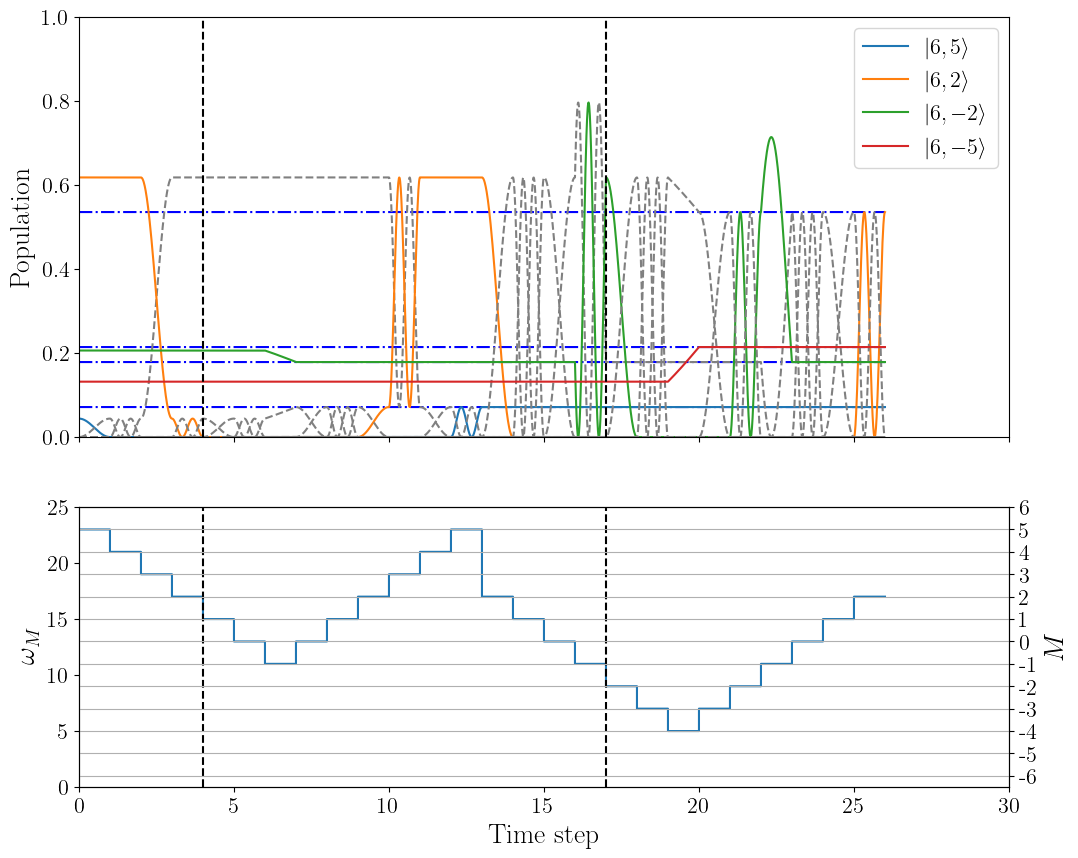

In [15]:
# creating grid for subplots
fig = plt.figure(figsize=(12,10))

spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[3, 2])

ax0 = fig.add_subplot(spec[0])
for i in range(len(JM)):
    if JM[i][0]==J and (JM[i][1]== M1 or JM[i][1]== M2 or JM[i][1] == -M2 or JM[i][1] == -M1 ):
        ax0.plot(tdata,pMi[i]*np.ones(len(tdata)),'b-.')

    elif JM[i][0]==Jd and (JM[i][1]== M1 or JM[i][1]== M2 or JM[i][1] == -M2 or JM[i][1] == -M1):# or JM[i][1] == -4):
        ax0.plot(tdata,pM[:,i],label=r'$|{},{} \rangle$'.format(JM[i][0],JM[i][1]))
    else:
        ax0.plot(tdata,pM[:,i],color='gray',linestyle='dashed',label=None)

ax0.plot(4*np.ones(10),np.linspace(0,1,10),linestyle='dashed',color='black')
ax0.plot(17*np.ones(10),np.linspace(0,1,10),linestyle='dashed',color='black')
ax0.set_ylim((0,1))

ax1 = fig.add_subplot(spec[1])
ax1.plot(tdata,ww[:-nstep])

ax1.plot(4*np.ones(10),np.linspace(0,25,10),linestyle='dashed',color='black')
ax1.plot(17*np.ones(10),np.linspace(0,25,10),linestyle='dashed',color='black')
ax1.set_ylim((0,25))

ax1.sharex(ax0)

ax1.set_xlabel(r'Time step',fontsize=20,labelpad=5)
ax0.set_ylabel('Population',fontsize=20,labelpad=5)
ax1.set_ylabel(r'$\omega_M$',fontsize=20,labelpad=5)
ax0.legend(loc='upper right')#, bbox_to_anchor=(1.01, 0.65))
plt.setp(ax0.get_xticklabels(), visible=False)

ax2 = ax1.twinx()
Mi = M1+1
new_tick_locations = [abs(args['chi']*(2*(M)-1)+args['omega0']) for M in np.linspace(Mi,-Mi,int(2*Mi+1))]

def tick_function():
    V = np.linspace(Mi,-Mi,int(2*Mi+1))
    return ["%.0f" % z for z in V]

ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(new_tick_locations)
ax2.set_yticklabels(tick_function())
ax2.grid()
ax2.set_ylabel(r'$M$',fontsize=20,labelpad=5)#,labelpad=6,fontsize=18)
# ax0.text(-0.15, 10., "(a)", va='center',fontsize=fontsize-1)
# ax1.text(-0.15, 5., "(b)", va='center',fontsize=fontsize-1)

plt.xlim((0,30))
plt.savefig("CollectiveControl.pdf",bbox_inches='tight',dpi=600)
plt.show()

In [16]:
pMi[:2*7+1]

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.07142857142857144),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.5357142857142856),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.17857142857142858),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.21428571428571427),
 np.float64(0.0),
 np.float64(0.0)]

In [17]:
pMe[2*7+1:15+13]

[np.float64(0.0),
 np.float64(0.07141717351027697),
 np.float64(3.563283476902638e-06),
 np.float64(-2.9362051615398255e-06),
 np.float64(0.5356697651425403),
 np.float64(1.286714494556315e-05),
 np.float64(3.6383292082381156e-05),
 np.float64(1.2867973681072241e-05),
 np.float64(0.1785485085338558),
 np.float64(1.0186651160515535e-05),
 np.float64(8.960538994265148e-06),
 np.float64(0.214282660134148),
 np.float64(0.0)]

In [18]:
idx = np.nonzero(RhoI.data_as("ndarray"))
idx1 = (2*7 + idx[0], 2*7 + idx[1])

In [19]:
RhoI[idx].real

array([0.07142857, 0.1956152 , 0.11293849, 0.12371791, 0.1956152 ,
       0.53571429, 0.30929479, 0.33881546, 0.11293849, 0.30929479,
       0.17857143, 0.1956152 , 0.12371791, 0.33881546, 0.1956152 ,
       0.21428571])

In [20]:
(RhoEr).tidyup()[idx1].real

array([0.07141717, 0.19561435, 0.1129377 , 0.12371757, 0.19561435,
       0.53566977, 0.3092164 , 0.33881226, 0.1129377 , 0.3092164 ,
       0.17854851, 0.19560602, 0.12371757, 0.33881226, 0.19560602,
       0.21428266])

In [21]:
LSt = EncodedSt(M1, M2, α, β, 1, N, Jd)
qt.fidelity(LSt,RhoEr)

0.9999578954512871